# Recovery of Heard Speech Spectrograms

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from algorithms import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X = getX(1, 'MS01')
print('X found')
Y = getY(1, 'MS01')
print('Y found')
A = getA(1, 'MS01', lam=1)
print('A found')

X found
Y found
A found


In [3]:
print(X.shape, Y.shape, A.shape)

(2304, 5624) (64, 5624) (64, 2304)


In [4]:
np.linalg.norm(Y-A@X, 'fro')/np.prod(Y.shape)

0.0015720156379853663

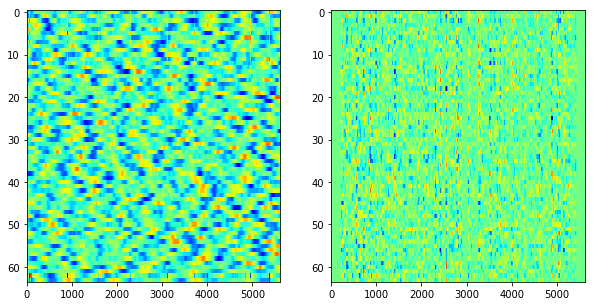

In [5]:
# %matplotlib qt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(saturate(Y), aspect='auto',cmap='jet')
plt.subplot(122)
plt.imshow(saturate(A@X), aspect='auto',cmap='jet')
plt.show()

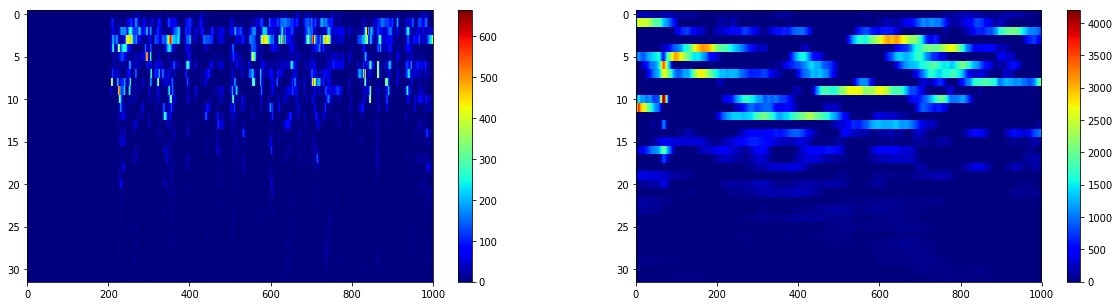

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(X[:32,:1000], aspect='auto',cmap='jet')
plt.colorbar()
plt.subplot(122)
rec = np.linalg.pinv(A)@Y
rec[rec<0] = 0
plt.imshow(rec[:32,:1000], aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

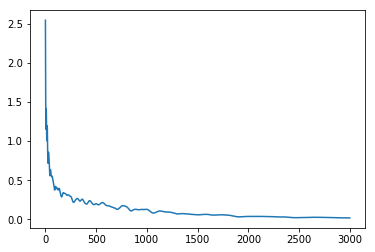

Error in objective (sparse) :  0.02005221876305095
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  1282.238537910856
Error in x (dense) :  1582.2624265796742


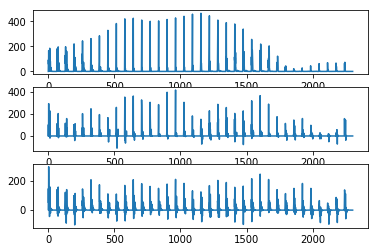

In [29]:
Y_new = A@X
u = 1000
alpha = 1.2
lamda = 1e-1
t = 600
x,v,err = ALM(A,Y_new[:,t],u,alpha,lamda,iters=3000)
show_result(A,Y_new,X,x,err,t)

0.02997759159056288


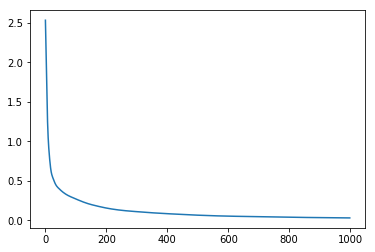

Error in objective (sparse) :  0.02997759159056288
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  1649.8238474461423
Error in x (dense) :  1582.2624265796742


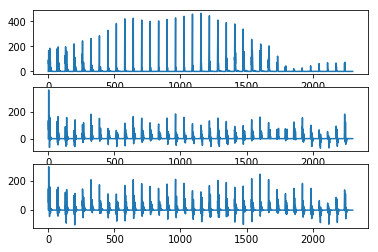

In [313]:
eig,_ = np.linalg.eig(np.dot(A.T,A))
alpha = 1/np.max(np.real(eig))
beta = 1
lamda = 1e-7
x,err = acc_prox_grad(A,Y_new[:,t],alpha,beta,lamda,iters=1000)
show_result(A,Y_new,X,x,err,t)

2.3280022703417345e-13


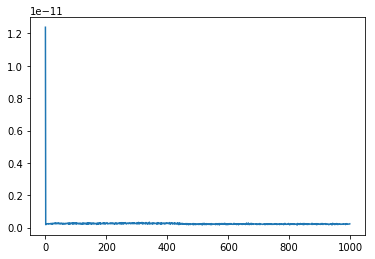

Error in objective (sparse) :  2.3280022703417345e-13
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  1281.8313736617426
Error in x (dense) :  1582.2624265796742


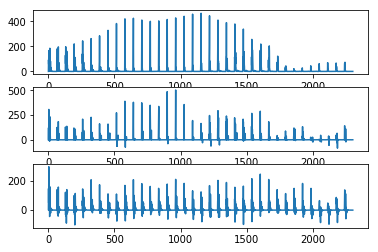

In [163]:
lr = 4e-1
x,err = proj_subgrad(A,Y_new[:,t],lr,iters=1000)
show_result(A,Y_new,X,x,err,t)

0.3932718615338798


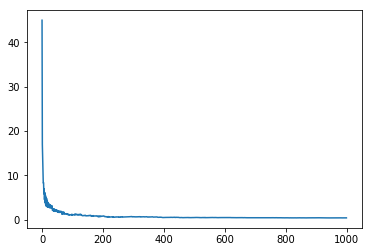

Error in objective (sparse) :  0.3932718615338798
Error in objective (dense) :  1.0558262582189763e-14
Error in x (sparse) :  3663.8151671446426
Error in x (dense) :  1582.2624265796742


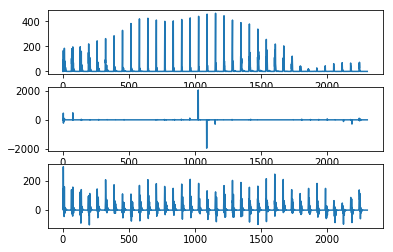

In [295]:
tau = 13000
x,v,err = FrankWolfe(A,Y_new[:,t],tau,iters=1000)
show_result(A,Y_new,X,x,err,t)